In [67]:
import pandas as pd
import numpy as np
import matplotlib.pylab as plt
from sklearn.metrics import mean_absolute_error
from sklearn import preprocessing
from preprocessing.preprocess_data import DataSet, make_categorical, ReLU, pred_to_delivery, remap, get_constant_indices
import catboost as cb

%matplotlib inline

pd.set_option('display.max_rows', 200)
pd.set_option('display.max_columns', 200)

In [68]:


selected_features = ['date_forecast', 'absolute_humidity_2m:gm3',
       'air_density_2m:kgm3', 'clear_sky_energy_1h:J',
       'clear_sky_rad:W', 'dew_or_rime:idx',
       'dew_point_2m:K', 'diffuse_rad:W', 'diffuse_rad_1h:J', 'direct_rad:W',
       'direct_rad_1h:J', 'effective_cloud_cover:p', 'elevation:m',
       'fresh_snow_6h:cm', 'is_day:idx',
       'is_in_shadow:idx', 'msl_pressure:hPa', 'precip_5min:mm',
       'pressure_100m:hPa', 'pressure_50m:hPa',
       'prob_rime:p', 'rain_water:kgm2', 'relative_humidity_1000hPa:p',
       'sfc_pressure:hPa', 'snow_depth:cm',
       'sun_azimuth:d', 'sun_elevation:d', 'super_cooled_liquid_water:kgm2',
       't_1000hPa:K', 'total_cloud_cover:p', 'visibility:m',
       'wind_speed_10m:ms', 'wind_speed_u_10m:ms', 'wind_speed_v_10m:ms',
       'wind_speed_w_1000hPa:ms']

made_features = ['location', 'type', 'is_day:idx', 'is_in_shadow:idx', 'dew_or_rime:idx']

drop_feature = 'diffuse_rad:W'

In [69]:
data_collection = DataSet()
data_collection.select_features(selected_features)
data_collection.resample_to_hourly()
data_collection.remove_nans(drop_feature)
data_collection.add_location()
data_collection.add_type()
#
data_collection.combine_obs_est()
data_collection.drop_bad_data()
data_collection.cyclic_time_encoding()

In [70]:
local_test = False
y_scale = True
k_b = 5
k_c = 6


if y_scale:
    data_collection.scale_y_train()

for loc in ['a','b', 'c']:
    if 'is_in_shadow:idx' in made_features:
        data_collection.X_train[loc]['is_in_shadow:idx'] = data_collection.X_train[loc]['is_in_shadow:idx'].map(remap)

        data_collection.X_test_estimated[loc]['is_in_shadow:idx'] = data_collection.X_test_estimated[loc]['is_in_shadow:idx'].map(remap)

    make_categorical(data_collection.X_train[loc], made_features)
    data_collection.X_train[loc] = data_collection.X_train[loc].rename(columns={'date_forecast': 'time'})
    data_collection.X_train[loc] = data_collection.X_train[loc].reset_index(drop=True)
    data_collection.X_train[loc] = data_collection.X_train[loc].drop('time', axis=1)

    if 'date_calc' in data_collection.X_train[loc].columns:
        data_collection.X_train[loc] = data_collection.X_train[loc].drop('date_calc', axis=1)

    make_categorical(data_collection.X_test_estimated[loc], made_features)
    data_collection.X_test_estimated[loc] = data_collection.X_test_estimated[loc].rename(columns={'date_forecast': 'time'})
    data_collection.X_test_estimated[loc] = data_collection.X_test_estimated[loc].reset_index(drop=True)
    data_collection.X_test_estimated[loc] = data_collection.X_test_estimated[loc].drop('time', axis=1)

    if 'date_calc' in data_collection.X_test_estimated[loc].columns:
        data_collection.X_test_estimated[loc] = data_collection.X_test_estimated[loc].drop('date_calc', axis=1)


X_train_a = data_collection.X_train['a']
X_train_b = data_collection.X_train['b']
X_train_c = data_collection.X_train['c']

y_train_a = data_collection.Y_train['a']
y_train_b = data_collection.Y_train['b']
y_train_c = data_collection.Y_train['c']

if local_test:
        X_train_a , X_test_a, y_train_a, y_test_a = train_test_split(X_train_a, y_train_a, test_size=2160, shuffle=False)
        X_train_b , X_test_b, y_train_b, y_test_b = train_test_split(X_train_b, y_train_b, test_size=2160, shuffle=False)
        X_train_c , X_test_c, y_train_c, y_test_c = train_test_split(X_train_c, y_train_c, test_size=2160, shuffle=False)

else:
    X_test_a = data_collection.X_test_estimated['a']
    X_test_b = data_collection.X_test_estimated['b']
    X_test_c = data_collection.X_test_estimated['c']


In [71]:
train_pool_a = cb.Pool(
    X_train_a,
    y_train_a,
    cat_features = made_features
)
train_pool_b = cb.Pool(
    X_train_b,
    y_train_b,
    cat_features = made_features
)
train_pool_c = cb.Pool(
    X_train_c,
    y_train_c,
    cat_features = made_features
)

test_pool_a = cb.Pool(
        X_test_a,
        cat_features = made_features
    )
test_pool_b = cb.Pool(
        X_test_b,
        cat_features = made_features
    )
test_pool_c = cb.Pool(
        X_test_c,
        cat_features = made_features
    )

In [106]:
it = 10000

model_a = cb.CatBoostRegressor(
    iterations = it,
    depth = 9,
    learning_rate =0.01,
    loss_function ='MAE',
    cat_features = made_features
)

model_b = cb.CatBoostRegressor(
    iterations = it,
    depth = 9,
    learning_rate =0.01,
    loss_function ='MAE',
    cat_features = made_features
)

model_c = cb.CatBoostRegressor(
    iterations = it,
    depth = 9,
    learning_rate =0.01,
    loss_function ='MAE',
    cat_features = made_features
)

In [107]:
#train the model
model_a.fit(train_pool_a, silent=True)
# make the prediction using the resulting model
preds_a = model_a.predict(test_pool_a)

#train the model
model_b.fit(train_pool_b, silent=True)
# make the prediction using the resulting model
preds_b = model_b.predict(test_pool_b)

#train the model
model_c.fit(train_pool_c, silent=True)
# make the prediction using the resulting model
preds_c = model_c.predict(test_pool_c)

A MAE: 171.05178602514175
B MAE: 28.81513916250811
C MAE: 27.01824269195986


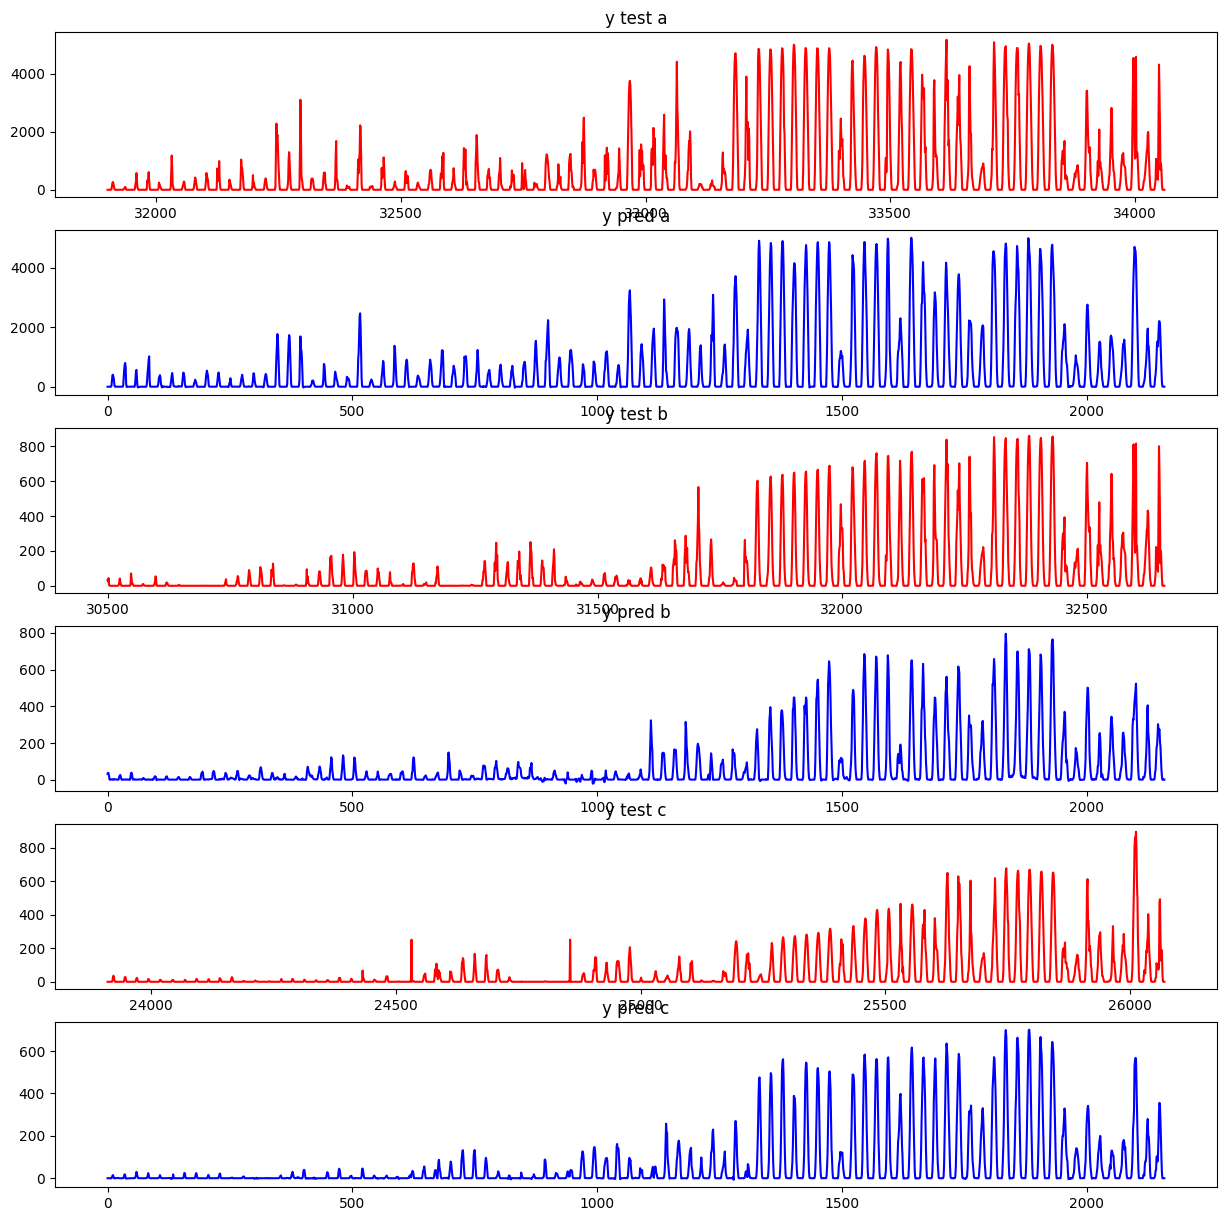

In [108]:
if local_test:
    print(f'A MAE: {mean_absolute_error(preds_a, y_test_a)}')
    print(f'B MAE: {mean_absolute_error(preds_b, y_test_b)}')
    print(f'C MAE: {mean_absolute_error(preds_c, y_test_c)}')
    diff_a = np.abs(y_test_a - preds_a)
    diff_b = np.abs(y_test_b - preds_b)
    diff_c = np.abs(y_test_c - preds_c)
    y_test = pd.DataFrame({'a':y_test_a , 'b': y_test_b , 'c':y_test_c})
    diff = pd.DataFrame({'a': diff_a, 'b' : diff_b, 'c':diff_c})

preds_df = pd.DataFrame({'a': preds_a,'b' : preds_b,'c' : preds_c})

if local_test:
    fig, axs = plt.subplots(6,1,figsize = (15,15))
    y_test['a'].plot(ax=axs[0], title='y test a', color='red')
    preds_df['a'].plot(ax=axs[1], title='y pred a', color='blue')
    y_test['b'].plot(ax=axs[2], title='y test b', color='red')
    preds_df['b'].plot(ax=axs[3], title='y pred b', color='blue')
    y_test['c'].plot(ax=axs[4], title='y test c', color='red')
    preds_df['c'].plot(ax=axs[5], title='y pred c', color='blue')
else:
    fig, axs = plt.subplots(3,1,figsize = (15,15))
    preds_df['a'].plot(ax=axs[0], title='y pred a', color='blue')
    preds_df['b'].plot(ax=axs[1], title='y pred b', color='red')
    preds_df['c'].plot(ax=axs[2], title='y pred c', color='green')



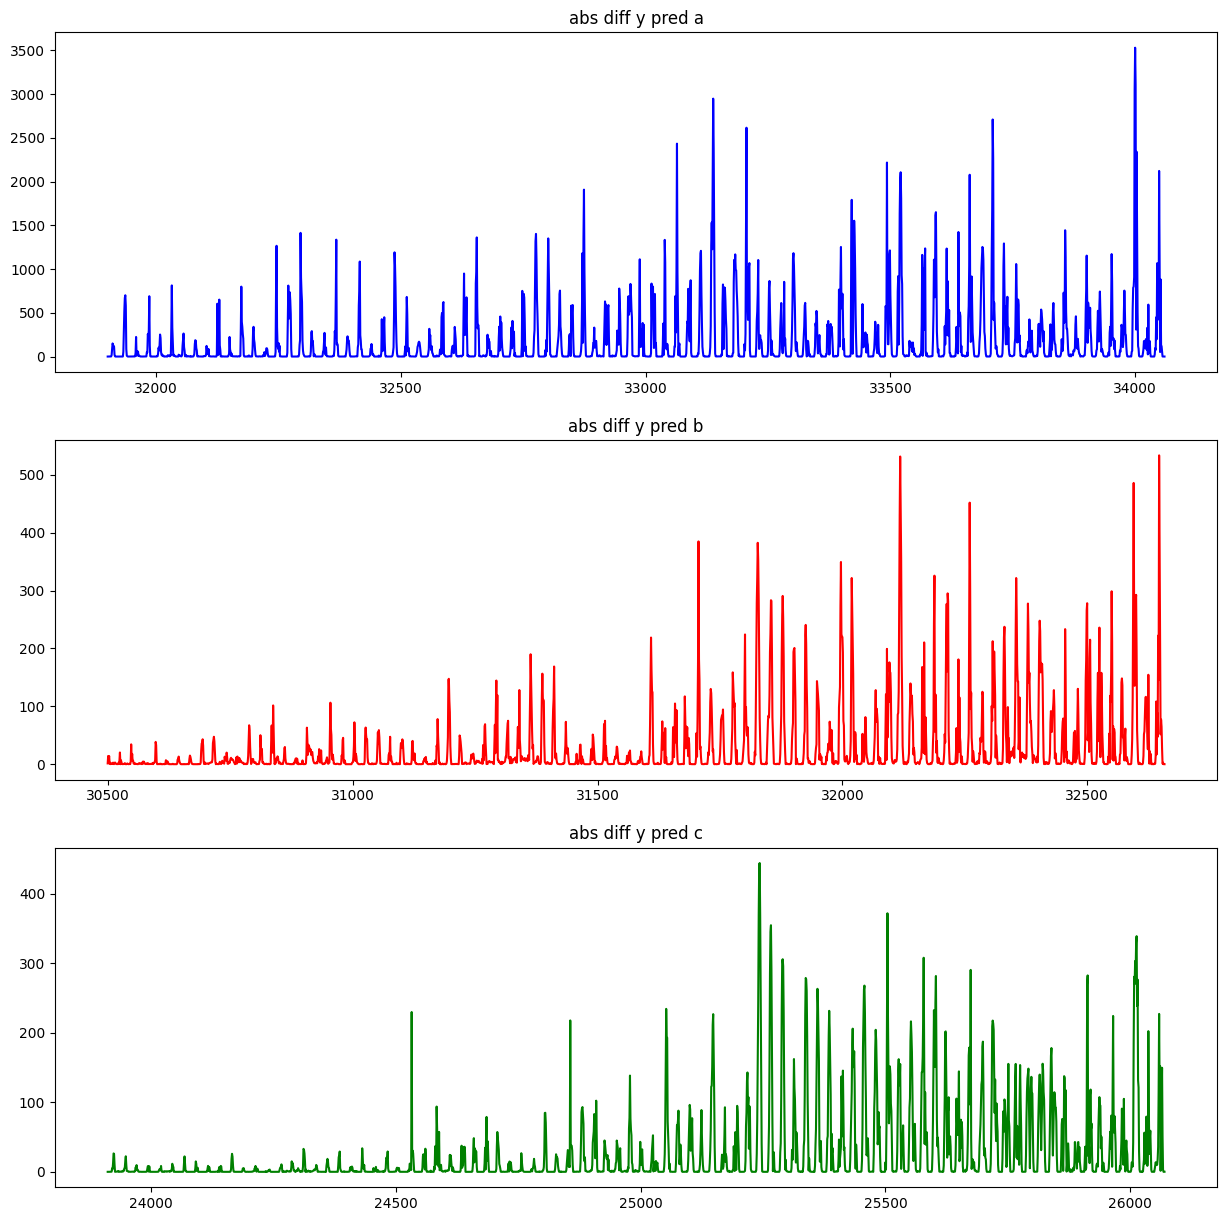

In [109]:
if local_test:
    fig, axs = plt.subplots(3,1,figsize = (15,15))
    diff['a'].plot(ax=axs[0], title='abs diff y pred a', color='blue')
    diff['b'].plot(ax=axs[1], title='abs diff y pred b', color='red')
    diff['c'].plot(ax=axs[2], title='abs diff y pred c', color='green')
